# Baby Cry Classification using Machine Learning Algorithms

**Author**: Jing Chen and Shruti Biradar

## Project Overview - purpose and our solution

**Project Goal**: In the first phase of our research, we aim to classify baby cry based on demographic features of babies and the acoustic cry signals using machine learning techniques and then compare the performance of the different machine learning methods based on the F1 Score metric. 

**Inputs**: 
*   Audio files in .wav format including file name
*   Acoustic features extracted from audio waves of baby cries, such as Mel-frequency cepstral coefficients and chroma features 
*   Demographic features of babies such as age and gender









**Outputs**: Labels of cry reasons:  
*   belly pain 
*   burping 
*   discomfort 
*   hunger
*   tiredness












### Structure of Code    

        I. Install and Import Packages  

        II. Load Dataset- audio files

        III. Exploratory Data Analysis

        IV. Pre-processing and Feature Extraction

        V. Build Classifier

        VI. Run all models and Report Performance

## I. Install and Import packages

In [ ]:
# load required packages
!pip install pydub

import wave 
import math
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import wave
import pandas as pd
import numpy as np
import pydub
from scipy.io.wavfile import read
from pydub import AudioSegment
from pydub.utils import make_chunks
from os import walk
from os import listdir
from os.path import isfile, join
import random
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import pyplot
from sklearn.model_selection import train_test_split,cross_validate,RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score,precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.preprocessing import MinMaxScaler,StandardScaler,normalize,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold,GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE 
from collections import Counter
from numpy.linalg import eigh
from sklearn.svm import SVC
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from datetime import datetime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## II. Load Dataset- audio files

We use Donate-A-Cry corpus dataset, which consists of 457 unique child cry audio files along with tags for babies’ demographic information (age and gender) and cry reasons (such as hungry, belly pain, discomfort, burping, and tiredness). 

In [ ]:
# create a data frame that contains all file path of audio files and associated label for cry reason
dic_path = os.getcwd()
sub_folder_name = ["belly_pain","burping","discomfort","hungry","tired"]
file_path_df = pd.DataFrame(columns=['file_name','audio_type'])
for t in sub_folder_name:
    wav_files = [dic_path+"/audio/"+t+"/"+ f for f in os.listdir(dic_path +"/audio/"+t) if f.endswith(".wav")]
    temp_df = pd.DataFrame({ "file_name" : wav_files, "audio_type" : t})
    file_path_df = pd.concat([file_path_df, temp_df], ignore_index=True)

In [ ]:
# a snippet of the dataframe
file_path_df.head(6)

,file_name,audio_type
0,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain
1,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain
2,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain
3,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain
4,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain
5,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain


## III. Exploratory Data Analysis

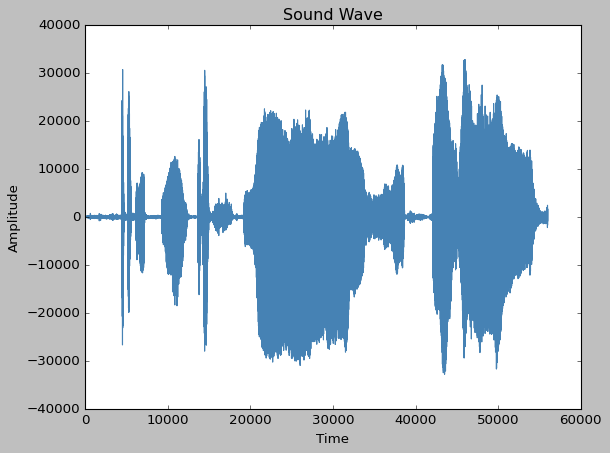

In [ ]:
# visualize one sample audio wave 
input_data = read(file_path_df["file_name"][1])
audio_sample = input_data[1]
plt.style.use('classic')
plt.plot(audio_sample, color = "steelblue")
plt.title("Sound Wave")
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

In [ ]:
# extract length of file, age and gender of babies from the files and append to the dataframe 

def calculate_audio_length(file_path):
    # load audio file using file path and calculate the length of audio in minutes
    y,sr = librosa.load(file_path)
    length = len(y)/sr
    return length

def extract_gender(file_path):
    # extract information on gender from file name
    g = file_path.split("-")[-3]
    if g == "m":
        return "Male"
    else: return "Female"

def extract_age(file_path):
    # extract information on age in month from file name
    a = int(file_path.split("-")[-2])
    return a

In [ ]:
file_path_df["length"] = file_path_df["file_name"].map(lambda x:calculate_audio_length(x))
file_path_df["gender"] = file_path_df["file_name"].map(lambda x:extract_gender(x))
file_path_df["age_in_months"] = file_path_df["file_name"].map(lambda x:extract_age(x))

In [ ]:
file_path_df.head(6)

,file_name,audio_type,length,gender,age_in_months
0,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain,6.84,Male,4
1,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain,7.00,Male,26
2,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain,7.00,Male,72
3,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain,7.00,Male,72
4,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain,6.82,Male,4
5,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain,7.00,Male,72


### Gender

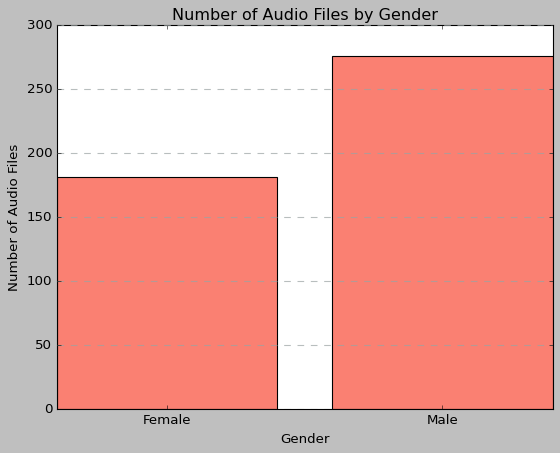

In [ ]:
count_by_gender = pd.DataFrame(file_path_df.groupby(['gender']).size()).rename(columns={0: "count"})
count_by_gender.reset_index(inplace=True)
plt.bar(count_by_gender['gender'], count_by_gender['count'],color = "salmon")
plt.grid(color='#9ba3a3', linestyle='--', linewidth=1, axis='y', alpha=0.7)
plt.xlabel('Gender')
plt.ylabel('Number of Audio Files')
plt.title('Number of Audio Files by Gender')
plt.show()

**Observation:** from the above graph we can tell that we have approx. 100 more audio data for male babies than female.

### Age

In [ ]:
file_path_df['age_in_months'].apply(["max","median","min"])

max       72.0
median    26.0
min        4.0
Name: age_in_months, dtype: float64

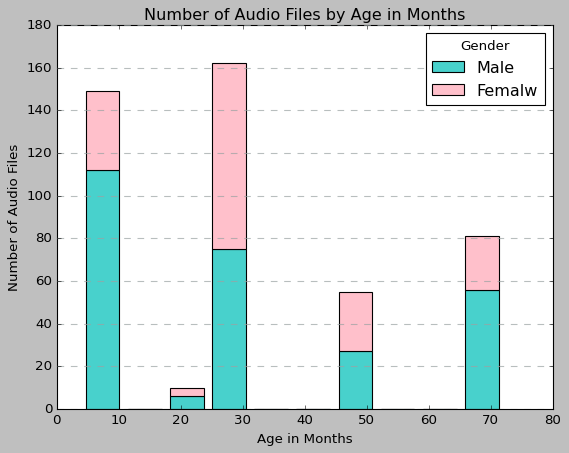

In [ ]:
# Create list of data according to different gender
x1 = list(file_path_df[file_path_df['gender'] == "Male"]['age_in_months'])
x2 = list(file_path_df[file_path_df['gender'] == "Female"]['age_in_months'])
 
colors=['mediumturquoise', 'pink']
names=['Male', 'Femalw']
 
plt.hist([x1, x2], color=colors, label=names, stacked = True)
plt.grid(color='#9ba3a3', linestyle='--', linewidth=1, axis='y', alpha=0.7)
plt.xlabel('Age in Months')
plt.ylabel('Number of Audio Files')
plt.title('Number of Audio Files by Age in Months')
plt.legend(title='Gender')
plt.show() 

**Observation:** The above information tells us that age of babies ranges from 4 months to 74 months(6 years). Most of the babies in our data are in the age group of 4months to slightly over 30 months.

### Audio Length

In [ ]:
file_path_df['length'].apply(["max","median","min"])

max       7.06
median    6.96
min       6.52
Name: length, dtype: float64

**Observation:** This ranges from 6.52 to 7.06, therefore we have 6-7 segements for the audio files.

### Cry Reason

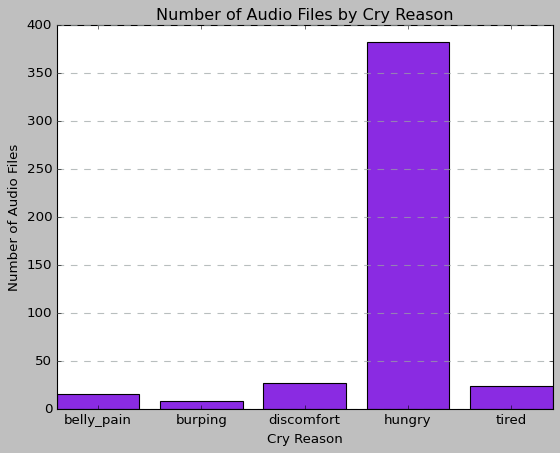

In [ ]:
count_by_type = pd.DataFrame(file_path_df.groupby(['audio_type']).size()).rename(columns={0: "count"})
count_by_type.reset_index(inplace=True)
plt.bar(count_by_type['audio_type'], count_by_type['count'],color = "blueviolet")
plt.grid(color='#9ba3a3', linestyle='--', linewidth=1, axis='y', alpha=0.7)
plt.xlabel('Cry Reason')
plt.ylabel('Number of Audio Files')
plt.title('Number of Audio Files by Cry Reason')
plt.show()

**Observation:**
From the above graph it is clear that we have significantly higher number of audio files for cry reason 'hunger' than others. The other classes have more or else equal amount of data. 

## IV. Feature Extraction and Dimentionality Reduction

**(1)** Framing:  For an audio file, the waveform is cut into segments with a duration of 1-second

**(2)** Feature Extraction

| Acoustic Feature | Definition | Number of Features Extracted per Frame |
| :-: |:-- | :-: |
| Mel-frequency cepstral coefficients (MFCC)| A set of features derived from log short-term power spectrum of a sound signal  on a nonlinear mel scale of frequency| 39 |
| Spectral Centroid| A number that represents the amplitude at the center of the spectrum of the signal distribution over a window calculated from the Fourier transform frequency.  $$
   Spectral\space Centroid = \frac{\sum\limits_{n=0}^{N-1} f(n)x(n)}{\sum\limits_{n=0}^{N-1} x(n)}
$$ <br> where x(n) is the weighted frequency value of nth bin, and f(n) is the center frequency of nth bin.| 1 |
| Spectral Flatness| A measure that quantifies how much a sound resembles a pure tone rather than noise <br> <br> $${{Spectral\space Flatness}}={\frac  {\exp \left({\frac  {1}{N}}\sum _{{n=0}}^{{N-1}}\ln x(n)\right)}{{\frac  {1}{N}}\sum _{{n=0}}^{{N-1}}x(n)}}$$ <br> where x(n) represents the magnitude of nth bin.| 1 |
| Spectral Contrast| The decibel difference between peaks and valleys in the spectrum| 7  |
| Spectral Rolloff| The frequency below which 85% of the magnitude distribution is concentrated | 1  |
| Chroma Features| A set of features represent the tonal content of a musical audio signal in a condensed form. | 12 |

**(3)** Flattening Features: Each 2-D acoustic feature is converted into 1-d vector before passing as input in the next process by flattening.

**(4)** Dimentionality Reduction and Standardization: We are using use standardization as our scaling method to have data centered around the mean with unit std. deviation in each column and we also do PCA for reducing some 1000+ features to key features that captures most of the information about the data.


In [ ]:
def processing_audio(audio_df = file_path_df.head(), n_second = 1):
    i = 0
    gender = []
    age = []
    cry_reason = []
    mfccs = []
    spectral_centriod = []
    spectral_flatness = []
    spectral_contrast = []
    spectral_rolloff = []
    chroma_features = []
    audio_index = []
    for f in audio_df["file_name"]:
        y, s = librosa.load(f)
        while len(y)>= s*n_second:
            gender.append(f.split("-")[-3])
            age.append(f.split("-")[-2])
            cry_reason.append(audio_df["audio_type"][i])
            # Start from dividing the sound signal into the form of frames with a duration of 1-seconds
            f1 = y[:s*n_second]
            y = y[s*n_second:]
            # Extract Mel-frequency cepstral coefficients (MFCCs) to represent the short-term power spectrum of sound. 
            mfcc = librosa.feature.mfcc(y=f1, sr=s, n_mfcc=19)
            mfccs.append(mfcc)
            # Extract Spectral Centriod
            cent = librosa.feature.spectral_centroid(y=f1, sr=s)
            spectral_centriod.append(cent)
            # Extract Spectral flatness
            flat = librosa.feature.spectral_flatness(y=f1)
            spectral_flatness.append(flat)
            # Extract Spectral contrast
            S = np.abs(librosa.stft(f1))
            sc = librosa.feature.spectral_contrast(S=S, sr=s)
            spectral_contrast.append(sc)
            # Extract Spectral Rolloff
            rolloff = librosa.feature.spectral_rolloff(y=f1, sr=s)
            spectral_rolloff.append(rolloff)
            # Extract Chroma Features
            cf = librosa.feature.chroma_stft(y=f1, sr=s)
            chroma_features.append(cf) 
            audio_index.append(i)
        i += 1
    output_df = pd.DataFrame({"audio_index": audio_index,
                              "gender" : gender,
                              "age" : age,
                              "cry_reason" : cry_reason,
                              "mfcc" : mfccs,
                              "spectral_centroid": spectral_centriod,
                              "spectral_flatness": spectral_flatness,
                              "spectral_contrast": spectral_contrast,
                              "spectral_rolloff" : spectral_rolloff,
                              "chroma_features": chroma_features})
    return output_df

In [ ]:
def convert_matrix_vector_to_df(matrix_vector):
    # convert a vector of matrix to a vector of arrays by flattening all nested arrays
    flatten_df = matrix_vector.flatten()
    return flatten_df

In [ ]:
def convert_matrix_to_columns(data, column_name):
    # if the first cell of the column is a matrix then convert this column into multiple columns by flattening the matrix
    df = data[column_name].map(lambda x:convert_matrix_vector_to_df(x))
    temp_df = pd.DataFrame(df.tolist(),index = df.index)
    temp_df.columns = [column_name + f'{c}' for c in temp_df.columns]
    data = pd.concat([data,temp_df],axis =1)
    data = data.drop([column_name], axis=1)
    return data

In [ ]:
def feature_extraction(file_path_df):
    data_df = processing_audio(audio_df = file_path_df, n_second = 1)
    #2-D acoustic features are converted into 1-d vector before passing as input in the next process by flattening.
    flatten_data_df = data_df.copy()
    for column_name in data_df.columns:
        if type( data_df[column_name][0]) != str and not isinstance(data_df[column_name][0], (int, np.integer)) and (data_df[column_name][0].shape[0]*data_df[column_name][0].shape[1]>1):
            flatten_data_df = convert_matrix_to_columns(flatten_data_df, column_name)
    return data_df,flatten_data_df

In [ ]:
def derive_pc(X_train,X_test):
    # input: X matrix
    # output: principal components that explain at least 90% of the variance
    
    # Standardize X_train for classification
    X_train_standardized = StandardScaler().fit_transform(X_train)
    
     # Calculate the Eigenvectors and eigenvalues    
    covariance_matrix = np.cov(X_train_standardized.T)
    eigen_values, eigen_vectors = eigh(covariance_matrix)

    # Calculate share of explained variance by number of features
    tot = sum(eigen_values)
    variance_explained = [(i/tot)*100 for i in sorted(eigen_values, reverse=True)] 
    cum_variance_explained = np.cumsum(variance_explained) 
    
    # Find the smallest number of features that explain at least 90% of the variance
    eigen_count = next(x for x, val in enumerate(cum_variance_explained)if val > 90) + 1  

    # Calculate principal components
    pca = PCA(n_components= eigen_count)
    pca.fit(X_train_standardized)
    X_train_pc = pca.transform(X_train_standardized)
    
    # Sandardize and normalize X_test matrix
    X_test_standardized = StandardScaler().fit_transform(X_test)
    X_test_pc = pca.transform(X_test_standardized)
    
    return X_train_pc, X_test_pc
    

## V. Build Classifiers

#### Baseline Model

**Baseline Model** predicts the label with majority group in training data

In [ ]:
def baseline(X_train, X_test, y_train, y_test):
    # baseline predicts the cry reason with majority group in y_train
    stats = Counter(y_train)
    majority_group = max(stats, key=lambda key: stats[key])
    y_pred = [majority_group for i in range(y_test.shape[0])]
    return y_pred

#### Random Forest

**Random Forest (RF)**: RF combines the outputs of all decision trees (DT) to generate a single classification label.  

For each DT:

(1) Draw a bootstrap sample of size N from training data  

(2) Grow a RF tree with bootstrap sample by recursively repeat the steps below  at node until hyperparameter setting  is reached.

    Select a subset of variable at random  
    Perform partition

Combine the output of all trees by taking the majority vote of classification prediction from all trees.


In [ ]:
def rf_pca(X_train, X_test, y_train, y_test):
    
    # Derive principal components of X_train and X_test
    X_train_pc, X_test_pc = derive_pc(X_train, X_test)
    
    # Set hyperparameters grid
    n_estimators = [int(i*100) for i in range(1, 2, 1)] # Number of trees in random forest
    # n_estimators = [int(i*100) for i in range(2, 5, 1)] # Number of trees in random forest
    max_features = [None]
    max_depth = [int(i) for i in range(5, 8, 2)] # Maximum number of levels in tree
    max_depth.append(None)
    min_samples_split = [2] # Minimum number of samples required to split a node
    min_samples_leaf = [1] # Minimum number of samples required at each leaf node
    bootstrap = [True] # Method of selecting samples for training each tree
    # Create the hyperparameter grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    # Set the base model
    rf_pca_model = RandomForestClassifier()
    # Find the hyperparameter combination that returns the best result
    rf_pca_model_optimal = GridSearchCV(estimator = rf_pca_model,
                                        param_grid = random_grid,
                                        cv = 2,# 2-fold cross validation,
                                        verbose=2,# the computation time for each fold, parameter candidate, and the score are displayed
                                        n_jobs = -1) #using all processor
    
    rf_pca_model_optimal.fit(X_train_pc, y_train)
    
    y_pred = rf_pca_model_optimal.predict(X_test_pc)
    
    return y_pred

#### Balanced Random Forest (BRF)

An BRF classifier randomly under-samples each boostrap sample to balance it. In other words, BRF iteratively draw a bootstrap sample with equal proportions of data points from both the minority and the majority class. 

In [ ]:
def brf_pca(X_train, X_test, y_train, y_test):
    
    # Derive principal components of X_train and X_test
    X_train_pc, X_test_pc = derive_pc(X_train, X_test)
    
    # Build random forest model
    rf_pca_model = BalancedRandomForestClassifier(n_estimators = 150)
    rf_pca_model = rf_pca_model.fit(X_train_pc,y_train)

    y_pred = rf_pca_model.predict(X_test_pc)
    return y_pred

#### Random Forest - SMOTE (Synthetic Minority Oversampling Technique)

SMOTE works by generating instances that are close in feature space, using interpolation between positive cases that are close to each other. It randomly selects a minority class instance and finds its nearest neighbour. `

In [ ]:
def rf_smote(X_train, X_test, y_train, y_test):
    
    #Use SMOTE to oversample the minority class
    oversample = SMOTE()
    over_X_train, over_y_train = oversample.fit_resample(X_train, y_train)
    # Build random forest model
    SMOTE_SRF = RandomForestClassifier(n_estimators=150, random_state=0)
    # Model fitting with data with smote data
    SMOTE_SRF.fit(over_X_train, over_y_train)
    y_pred = SMOTE_SRF.predict(X_test)
    return y_pred

#### Class-Weighted Support Vector Machine (SVM)

SVM has been widely used for pattern recognition tasks due to its ability to handle nonlinear decision boundaries and for its resistance to outliers. It is used for classification as it finds the best hyperplane that separates the data pts of different classes while maximizing the margin between them.

We select "balanced" for class_weight, which uses the values of y_train to adjust weights inversely proportional to class frequencies in the training data

In [ ]:
def grid_svm(X_train, X_test, y_train, y_test):
    
    # Derive principal components of X_train and X_test
    X_train_pc, X_test_pc = derive_pc(X_train, X_test)
    
    # Create the hyperparameter grid
    #kernels: calculate the similarity or distance between pairs of data points and transform data to higher dimensional space
    #gamma: determines the influence of a single training point. Mostly used for non-linear kernels like RBF
    #C: it is the regularization paramerter which determines penalty for misclassifying training examples.
    #degree: determines the degree of the polynomial used to compute the kernel function in case of polynomial kernel
    param_grid = [{'kernel': ['linear','rbf','poly','sigmoid'],
                    'gamma': [1e-2,1e-3],
                    'C': [1,10,100],
                    'degree':[2,3]}]
    
    # Set the base model with class_weight as balanced
    svm_grid_model = SVC(class_weight='balanced')
    
    # Find the hyperparameter combination that returns the best result
    svm_grid_model_optimal = GridSearchCV(estimator = svm_grid_model,
                                        param_grid = param_grid,
                                        refit=True, # refit the model with best paramter on the dataset 
                                        cv = 2,# 2-fold cross validation,
                                        verbose=2,# the computation time for each fold, parameter candidate, and the score are displayed
                                        n_jobs = -1) #using all processor
    
    svm_grid_model_optimal.fit(X_train_pc, y_train)
    y_pred = svm_grid_model_optimal.predict(X_test_pc)
    
    return y_pred

#### Convolution Neural Network (CNN)

CNN is used for audio classification because of its ability to effectively capture local and global patterns in spectograms and other audio representations.

In the below implementation, we have so far just used MFCC features but plan to add the rest of the audio features as inputs.

Currently we are converting data to grayscal image but intend to test with color image dimensions

CNN model structure:
We will build a squential model with 3 conv2D layers and the output layer being a dense layer.As we have 5 class labels, the output layer has 5 nodes.

In [ ]:
def cnn_structure(x_train,x_test,num_labels=5):
  #parametrs for input into the model
  num_rows = 19 #corresponds to height of an image
  num_columns = 44 #corresponds to width of an image
  num_channels = 1 #channels in an image, 1 suggests its a grayscale image

  #reshape our input data to match the 

  x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
  x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

  # Construct model
  model = Sequential()

  # Add convolution layers
  model.add(Conv2D(32,(3,3), input_shape=(num_rows, num_columns, num_channels), activation='relu', padding='SAME'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.3))

  model.add(Conv2D(64,(3,3), activation='relu', padding='SAME'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.5))
  
  model.add(Conv2D(128,(3,3), activation='relu', padding='SAME'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.2))

  # output feature map to flattened vector
  model.add(Flatten())

  # Add fully connected layers
  model.add(Dense(64, activation='relu'))
  
  model.add(Dense(5, activation='softmax'))

  return model

In [ ]:
#Train the model
def cnn_model(x_train,x_test,y_train, y_test):

  #convert the mfcc and label columns to arrays
  X_train = np.array(x_train.tolist())
  y_train = np.array(y_train.tolist())
  X_test = np.array(x_test.tolist())
  y_test = np.array(y_test.tolist())

  # label encoding
  le = LabelEncoder()
  y_train = to_categorical(le.fit_transform(y_train))
  y_test = to_categorical(le.transform(y_test))

  #build model architecture
  model = cnn_structure(X_train,X_test,5)

  # Compile the model
  model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])

  num_epochs = 100 
  num_batch_size = 128

  # save the best training weights
  model_callback_checkpoint = ModelCheckpoint(filepath='cnn_model/bestmodel.h5',save_best_only=True, monitor='val_loss')
  history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[model_callback_checkpoint])

  # load the saved model 
  new_model = load_model('cnn_model/bestmodel.h5')
  
  # get model predictions on test data
  predictions = new_model.predict(X_test)

  # since the have our predictions in binary matrix we get the index of the highest prob value
  y_pred = np.argmax(predictions, axis = 1)

  # we apply inverse of label encoder to get the corresponding lables of the numeric values
  y_pred_labels = le.inverse_transform(y_pred)

  return history, y_pred_labels

## VII. Report Performance

In [ ]:
# Define function for reporting performance metrics

def report_performance(test_df,y_pred):
    # input: test data that contains both real label of cry reason and all features
    # output: a dictionary with metric names as keys. 
    
    # calculate the number of audios by cry reason
    test_count = test_df.groupby(['cry_reason']).size()
    reason_dict = test_count.to_dict()
    
    # build a function that only keeps the most frequent cry reason from an array
    def parse_pred(entry):
        if isinstance(entry, str):
            return entry
        return max(entry, key=lambda x: reason_dict[x])
    pred_dict = {'audio_index': test_df['audio_index'], 'y_test': test_df['cry_reason'], 'y_pred': y_pred} 
    temp_df = pd.DataFrame(pred_dict)
    
    # predict the entire audio's cry reason based on the majority group of predicted labels of its cuts
    temp_result = temp_df.groupby(['audio_index'])[['y_test','y_pred']].agg(pd.Series.mode)
    temp_result['y_pred'] = temp_result['y_pred'].map(parse_pred)
    
    # calculate precision, recall, and f1 based on the cry reason of orginal audio and predictions
    precision_1, recall_1,f1_1, null_value_1 = precision_recall_fscore_support(temp_result['y_test'],
                                                                               temp_result['y_pred'], 
                                                                               average='macro',
                                                                               zero_division=0)
    
    precision_2, recall_2,f1_2, null_value_2 = precision_recall_fscore_support(temp_result['y_test'],
                                                                               temp_result['y_pred'],
                                                                               average='weighted',
                                                                               zero_division=0)
    # calucate accuracy rate
    
    accuracy = accuracy_score(temp_result['y_test'],temp_result['y_pred'])
    return {
        'precision_macro': precision_1,
        'recall_macro': recall_1,
        'f1_macro': f1_1,
        'precision_weighted': precision_2,
        'recall_weighted': recall_2,
        'f1_weighted': f1_2,
        'accuracy': accuracy
    }

In [ ]:
### Run all models with K-fold cross validation

In [ ]:
### Feature Extraction
data_df, flatten_data_df = feature_extraction(file_path_df)

In [ ]:
# Divide data into 4 folds
arr = np.concatenate([[j for i in range(114)] for j in range(4)])
arr = np.concatenate([arr, [4]])
np.random.seed(101)
np.random.shuffle(arr)

def find_matching_k_fold_index(audio_index):
    return arr[audio_index]

flatten_data_df_p1 = pd.DataFrame(flatten_data_df['audio_index'].copy())
flatten_data_df_p1 = flatten_data_df_p1.rename(columns = {"audio_index":"k_fold_index"})
flatten_data_df_p2 = flatten_data_df.copy()
flatten_data_df = pd.concat([flatten_data_df_p1,flatten_data_df_p2],axis =1)
flatten_data_df['k_fold_index'] = flatten_data_df['k_fold_index'].map(lambda x:find_matching_k_fold_index(x))

In [ ]:
data_df_p1 = pd.DataFrame(data_df['audio_index'].copy())
data_df_p1 = data_df_p1.rename(columns = {"audio_index":"k_fold_index"})
data_df_p2 = data_df.copy()
data_df = pd.concat([data_df_p1,data_df_p2],axis =1)
data_df['k_fold_index'] = data_df['k_fold_index'].map(lambda x:find_matching_k_fold_index(x))

In [ ]:
# run all models and report cross-validation results

In [ ]:
models = ['baseline(X_train, X_test, y_train, y_test)',
          'grid_svm(X_train, X_test, y_train, y_test)',
          'rf_pca(X_train, X_test, y_train, y_test)',
          'brf_pca(X_train, X_test, y_train, y_test)',
          'cnn_model(X_train,X_test,y_train, y_test)']

In [ ]:
for model in models:
  print('model', model)
  for i in range(4):
        print('fold', i)
        if model != 'cnn_model(X_train,X_test,y_train, y_test)':
            train_df = flatten_data_df[flatten_data_df['k_fold_index']!=i]
            test_df = flatten_data_df[flatten_data_df['k_fold_index']==i]
            col = ['audio_index','cry_reason','gender','k_fold_index']
            X_train = train_df[[x for x in train_df.columns if x not in col]]
            y_train = train_df['cry_reason']
            X_test = test_df[[x for x in test_df.columns if x not in col]]
            y_test = test_df['cry_reason']
            y_pred = eval(model)
        else:
            train_df = data_df[data_df['k_fold_index']!=i]
            test_df = data_df[data_df['k_fold_index']==i]
            X_train = train_df['mfcc']
            y_train = train_df['cry_reason']
            X_test = test_df['mfcc']
            y_test = test_df['cry_reason']
            history, y_pred = eval(model)

        metrics_dict = report_performance(test_df,y_pred)
        if i == 0 and model == models[0]:
            metrics_df = pd.Series(metrics_dict).to_frame().T
            metrics_df['model_name'] = model.split('(')[0]
        else:
            temp_df = pd.Series(metrics_dict).to_frame().T
            temp_df['model_name'] = model.split('(')[0]
            metrics_df = pd.concat([metrics_df, temp_df],axis = 0)

model baseline(X_train, X_test, y_train, y_test)
fold 0
fold 1
fold 2
fold 3
model grid_svm(X_train, X_test, y_train, y_test)
fold 0
Fitting 2 folds for each of 48 candidates, totalling 96 fits
fold 1
Fitting 2 folds for each of 48 candidates, totalling 96 fits
fold 2
Fitting 2 folds for each of 48 candidates, totalling 96 fits
fold 3
Fitting 2 folds for each of 48 candidates, totalling 96 fits
model rf_pca(X_train, X_test, y_train, y_test)
fold 0
Fitting 2 folds for each of 3 candidates, totalling 6 fits
fold 1
Fitting 2 folds for each of 3 candidates, totalling 6 fits
fold 2
Fitting 2 folds for each of 3 candidates, totalling 6 fits
fold 3
Fitting 2 folds for each of 3 candidates, totalling 6 fits
model brf_pca(X_train, X_test, y_train, y_test)
fold 0


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para

fold 1


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para

fold 2


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para

fold 3


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para

model cnn_model(X_train,X_test,y_train, y_test)
fold 0
inside the code
model structued
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 19, 44, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 9, 22, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 9, 22, 32)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 9, 22, 64)         18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 4, 11, 64)        0         
 g2D)                                                            
                                 

In [ ]:
metrics_df

,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,accuracy,model_name
0,0.163158,0.200000,0.179710,0.665512,0.815789,0.733028,0.815789,baseline
0,0.161404,0.200000,0.178641,0.651277,0.807018,0.720831,0.807018,baseline
0,0.173684,0.200000,0.185915,0.754155,0.868421,0.807265,0.868421,baseline
0,0.170175,0.200000,0.183886,0.723992,0.850877,0.782323,0.850877,baseline
0,0.163158,0.200000,0.179710,0.665512,0.815789,0.733028,0.815789,grid_svm
0,0.161404,0.200000,0.178641,0.651277,0.807018,0.720831,0.807018,grid_svm
0,0.173684,0.200000,0.185915,0.754155,0.868421,0.807265,0.868421,grid_svm
0,0.170175,0.200000,0.183886,0.723992,0.850877,0.782323,0.850877,grid_svm
0,0.163158,0.200000,0.179710,0.665512,0.815789,0.733028,0.815789,rf_pca
0,0.161404,0.200000,0.178641,0.651277,0.807018,0.720831,0.807018,rf_pca


In [ ]:
cross_validation_result = metrics_df.groupby(['model_name']).mean()
cross_validation_result

,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,accuracy
model_name,,,,,,,
baseline,0.167105,0.200000,0.182038,0.698734,0.835526,0.760862,0.835526
brf_pca,0.209038,0.268779,0.157879,0.708683,0.302632,0.396108,0.302632
cnn_model,0.293798,0.239297,0.241889,0.747507,0.839912,0.778883,0.839912
grid_svm,0.167105,0.200000,0.182038,0.698734,0.835526,0.760862,0.835526
rf_pca,0.167105,0.200000,0.182038,0.698734,0.835526,0.760862,0.835526
